In [1]:
from generate_access_graph import generate_iam_test
import time
from z3 import Solver, sat, StringVal, BoolVal, unsat
import matplotlib.pyplot as plt

In [2]:
from numpy import average


def time_function(f, *args):
    start = time.perf_counter()
    result = f(*args)
    end = time.perf_counter()
    return (result, end-start)

def perform_test(params, id):
    test_instance = generate_iam_test(params)
    (user, action, res, path_len) = test_instance.generate_allow_test()
    print(user)
    print(action)
    print(res)
    s = Solver()
    s.add(test_instance.env['Allow'](StringVal(user), StringVal(action), StringVal(res)))
    (result, elapsed) = time_function(lambda: s.check())
    #print(f"test-{id}: params={params}; path_length={path_len}; num_roles={len(test_instance.role_graph)} q=Allow({user}, {action}, {res}); elapsed={elapsed}")
    if result == sat:
        print('sat')
    else:
        print('unsat')
    
    return {'result': result == 'sat', 'params': params, 'path_length': path_len, 'num_roles': len(test_instance.role_graph), 'q': f"Allow({user}, {action}, {res})", 
                                    'elapsed': elapsed}

def perform_averaged_test(params, iters=10):
    test_instance = generate_iam_test(params)

    times = []
    results = []
    for _ in range(iters):
        (user, action, res) = test_instance.generate_random_allow_test()
        s = Solver()
        s.add(test_instance.env['Allow'](StringVal(user), StringVal(action), StringVal(res)))
        #print(f"query: {test_instance.env['Allow'](StringVal(user), StringVal(action), StringVal(res))}")
        (result, elapsed) = time_function(lambda: s.check())
        if result == unsat:
            print('unsat!')
            s1 = Solver()
            s1.add(test_instance.env['TC_Access'](StringVal(user), StringVal(role)))
            print(f"checking access: {s1.check()}")

            s2 = Solver()
            s2.add(test_instance.env['Policy'](BoolVal(True), StringVal(role), StringVal(action),\
                            StringVal(res)))
            print(f"checking policy: {s1.check()}")
            assert result == sat


        times.append(elapsed)
        results.append(result)
    
    return {'result': results, 'params': params,  'num_roles': len(test_instance.role_graph), 
                                    'avg_elapsed': average(times)}

In [4]:
# test 1: 100 role groups, 100 users, vary path_length 
params1 = {
    'num_role_groups': 100,
    'roles_per_group': 4,
    'role_branching_factor': 3,
    'num_users': 100,
    'max_n_objects': 4,
    'max_n_actions': 3
}

branching_factors = [2*i for i in range(1, 20)]
points = []
path_lengths = []
for n in branching_factors:
    params1['role_branching_factor'] = n
    r = perform_test(params1, n)
    print(r)
    if r['path_length'] not in path_lengths:
        points.append(r['elapsed'])
        path_lengths.append(r['path_length'])

arn:aws:iam::14354624986284130233:user/user_95
s3:GetObjectRetention
test_object_541
sat
{'result': False, 'params': {'num_role_groups': 100, 'roles_per_group': 4, 'role_branching_factor': 2, 'num_users': 100, 'max_n_objects': 4, 'max_n_actions': 3}, 'path_length': 6, 'num_roles': 235, 'q': 'Allow(arn:aws:iam::14354624986284130233:user/user_95, s3:GetObjectRetention, test_object_541)', 'elapsed': 0.3605761930011795}
arn:aws:iam::14354624986284130233:user/user_84
s3:PutObject
test_object_1086
sat
{'result': False, 'params': {'num_role_groups': 100, 'roles_per_group': 4, 'role_branching_factor': 4, 'num_users': 100, 'max_n_objects': 4, 'max_n_actions': 3}, 'path_length': 8, 'num_roles': 238, 'q': 'Allow(arn:aws:iam::14354624986284130233:user/user_84, s3:PutObject, test_object_1086)', 'elapsed': 0.5002497749992472}
arn:aws:iam::14354624986284130233:user/user_42
s3:DeleteObjectVersion
test_object_1778
sat
{'result': False, 'params': {'num_role_groups': 100, 'roles_per_group': 4, 'role_bran

KeyboardInterrupt: 

In [3]:
plt.xlabel('Path Length in Role Graph')
plt.ylabel('Execution Time (s)')
plt.plot(sorted(path_lengths), points)

NameError: name 'plt' is not defined

In [10]:
# test 2: vary users and number of role groups (i.e., number of roles ~= k*n_users)
params2 = {
    'num_role_groups': 100,
    'roles_per_group': 4,
    'role_branching_factor': 3,
    'num_users': 100,
    'max_n_objects': 4,
    'max_n_actions': 3
}

sizes = [10*i for i in range(1, 50)]
points = []
for n in sizes:
    params2['num_users'] = n
    params2['num_role_groups'] = n
    r = perform_test(params2, n)
    print(r)
    points.append(r['elapsed'])


arn:aws:iam::14354624986284130233:user/user_4
s3:GetObjectAcl
test_object_54747
sat
{'result': False, 'params': {'num_role_groups': 10, 'roles_per_group': 4, 'role_branching_factor': 3, 'num_users': 10, 'max_n_objects': 4, 'max_n_actions': 3}, 'path_length': 3, 'num_roles': 21, 'q': 'Allow(arn:aws:iam::14354624986284130233:user/user_4, s3:GetObjectAcl, test_object_54747)', 'elapsed': 0.506389604001015}
arn:aws:iam::14354624986284130233:user/user_2
s3:PutObject
test_object_54865
sat
{'result': False, 'params': {'num_role_groups': 20, 'roles_per_group': 4, 'role_branching_factor': 3, 'num_users': 20, 'max_n_objects': 4, 'max_n_actions': 3}, 'path_length': 5, 'num_roles': 43, 'q': 'Allow(arn:aws:iam::14354624986284130233:user/user_2, s3:PutObject, test_object_54865)', 'elapsed': 0.17328534000080253}
arn:aws:iam::14354624986284130233:user/user_28
s3:InitiateReplication
test_object_54982
sat
{'result': False, 'params': {'num_role_groups': 30, 'roles_per_group': 4, 'role_branching_factor': 3

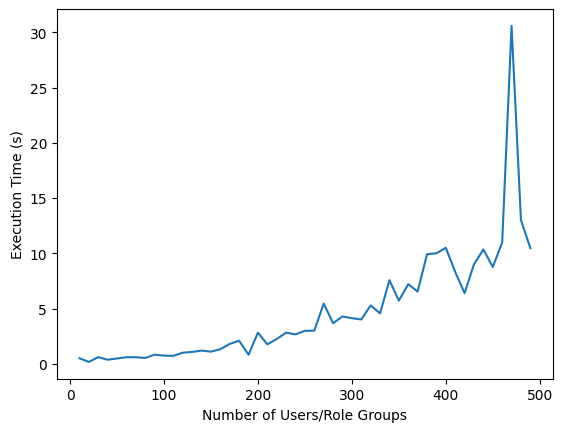

In [11]:
plt.xlabel('Number of Users/Role Groups')
plt.ylabel('Execution Time (s)')
plt.plot(sizes, points)

In [1]:
params7 = {
    'num_role_groups': 80,
    'roles_per_group': 4,
    'role_branching_factor': 3,
    'num_users': 240,
    'max_n_objects': 4,
    'max_n_actions': 3
}

params8 = {
    'num_role_groups': 160,
    'roles_per_group': 4,
    'role_branching_factor': 3,
    'num_users': 480,
    'max_n_objects': 4,
    'max_n_actions': 3
}

params9 = {
    'num_role_groups': 320,
    'roles_per_group': 4,
    'role_branching_factor': 3,
    'num_users': 960,
    'max_n_objects': 4,
    'max_n_actions': 3
}

In [11]:
perform_test(params7, id=1)

arn:aws:iam::14354624986284130233:user/user_63
s3:DeleteObject
test_object_48934
sat


{'result': False,
 'params': {'num_role_groups': 80,
  'roles_per_group': 4,
  'role_branching_factor': 3,
  'num_users': 240,
  'max_n_objects': 4,
  'max_n_actions': 3},
 'path_length': 7,
 'num_roles': 206,
 'q': 'Allow(arn:aws:iam::14354624986284130233:user/user_63, s3:DeleteObject, test_object_48934)',
 'elapsed': 20.941573382999195}

In [6]:
perform_test(params9, id=2)

arn:aws:iam::14354624986284130233:user/user_137
s3:GetObjectRetention
test_object_5828
sat


{'result': False,
 'params': {'num_role_groups': 320,
  'roles_per_group': 4,
  'role_branching_factor': 3,
  'num_users': 960,
  'max_n_objects': 4,
  'max_n_actions': 3},
 'path_length': 9,
 'num_roles': 784,
 'q': 'Allow(arn:aws:iam::14354624986284130233:user/user_137, s3:GetObjectRetention, test_object_5828)',
 'elapsed': 115.57802481300018}

In [18]:
perform_test(params8, id=3)

arn:aws:iam::14354624986284130233:user/user_164
s3:GetObjectRetention
test_object_52004
sat


{'result': False,
 'params': {'num_role_groups': 160,
  'roles_per_group': 4,
  'role_branching_factor': 3,
  'num_users': 480,
  'max_n_objects': 4,
  'max_n_actions': 3},
 'path_length': 9,
 'num_roles': 426,
 'q': 'Allow(arn:aws:iam::14354624986284130233:user/user_164, s3:GetObjectRetention, test_object_52004)',
 'elapsed': 30.273361627998383}

In [3]:
params3 = {
    'num_role_groups': 100,
    'roles_per_group': 4,
    'role_branching_factor': 3,
    'num_users': 100,
    'max_n_objects': 4,
    'max_n_actions': 3
}

sizes = [10*i for i in range(1, 50)]
avg_elapsed = []
for n in sizes:
    params3['num_users'] = n
    params3['num_role_groups'] = n
    r = perform_averaged_test(params3)
    print(r)
    avg_elapsed.append(r['avg_elapsed'])

{'result': [sat, sat, sat, sat, sat, sat, sat, sat, sat, sat], 'params': {'num_role_groups': 10, 'roles_per_group': 4, 'role_branching_factor': 3, 'num_users': 10, 'max_n_objects': 4, 'max_n_actions': 3}, 'num_roles': 16, 'avg_elapsed': 0.09093979109929932}
{'result': [sat, sat, sat, sat, sat, sat, sat, sat, sat, sat], 'params': {'num_role_groups': 20, 'roles_per_group': 4, 'role_branching_factor': 3, 'num_users': 20, 'max_n_objects': 4, 'max_n_actions': 3}, 'num_roles': 60, 'avg_elapsed': 0.11363584390019241}
{'result': [sat, sat, sat, sat, sat, sat, sat, sat, sat, sat], 'params': {'num_role_groups': 30, 'roles_per_group': 4, 'role_branching_factor': 3, 'num_users': 30, 'max_n_objects': 4, 'max_n_actions': 3}, 'num_roles': 81, 'avg_elapsed': 0.2232736482994369}
{'result': [sat, sat, sat, sat, sat, sat, sat, sat, sat, sat], 'params': {'num_role_groups': 40, 'roles_per_group': 4, 'role_branching_factor': 3, 'num_users': 40, 'max_n_objects': 4, 'max_n_actions': 3}, 'num_roles': 104, 'avg

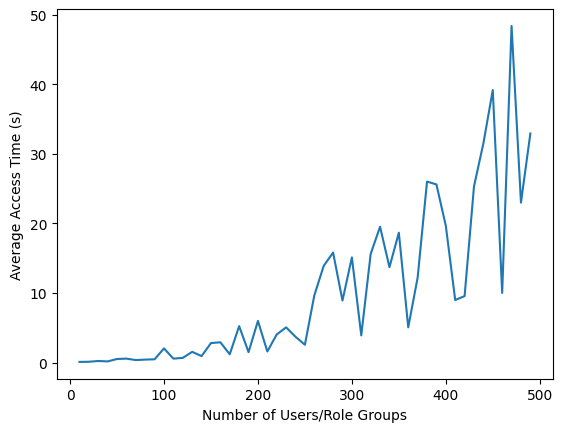

In [4]:
plt.xlabel('Number of Users/Role Groups')
plt.ylabel('Average Access Time (s)')
plt.plot(sizes, avg_elapsed)

In [15]:
import networkx as nx
import random

dg = nx.DiGraph([(1, 2), (2, 3), (3, 4), (4, 5)])


In [17]:
def rand_walk(dg, k):
    v = random.choice(list(dg.nodes))
    seen = 0
    path = []
    while seen < k:
        seen += 1
        path.append(v)
        if len(dg[v]) == 0:
            break
        else:
            v = random.choice(list(dg[v]))
    
    return path

rand_walk(dg, 2)


[1, 2]